# This is a script to run automated crawling

### Import necessary libaries

In [1]:
import json
import subprocess
import matplotlib.pyplot as plt
import pandas as pd

### Set plotting params

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

### Define needed constants

In [3]:
JAR_FILE_PATH = '/home/gorq/Desktop/vwm-odovzdanie/walker_2.0/walker_2.0.jar'
DB_URL = 'localhost:3306'
DB_NAME = 'market'
USERNAME = 'gorq'
PASSWORD = 'hesloheslo'

### Define an experiment class

In [4]:
class Experiment:
    def __init__(self, dct: dict) -> None:
        self._dct = dct
    
    @property
    def timeout(self) -> int:
        return self._dct['timeout']
    
    @property
    def request_limit(self) -> int:
        return self._dct['request limit']
    
    @property
    def ordering(self) -> str:
        return self._dct['ordering']
    
    @property
    def average_depth(self) -> float:
        return self._dct['average depth']
    
    @property
    def average_branching(self) -> float:
        return self._dct['average branching']
    
    @property
    def C(self) -> float:
        return self._dct['walker']['C']
    
    @property
    def acquired_amount(self) -> int:
        return self._dct['walker']['acquired amount']
    
    @property
    def unaccepted_amount(self) -> int:
        return self._dct['not accepted']
    
    @property
    def report_frequency(self) -> float:
        return self._dct['reporter']['frequency']
    
    @property
    def progress_list(self) -> list:
        return self._dct['reporter']['acquired times']
    
    def toPSV(self) -> str:
        return f'\
{self.timeout}|\
{self.request_limit}|\
{self.ordering}|\
{self.C}|\
{self.average_depth}|\
{self.average_branching}|\
{self.report_frequency}|\
{self.progress_list}|\
{self.acquired_amount}|\
{self.unaccepted_amount}\
'
    
    def graph(self) -> None:
        plt.rcParams['figure.figsize'] = (10, 7)
        plt.rcParams['font.size'] = 15
        plt.ylabel('Acquired amount')
        plt.xlabel('Time passed (seconds)')
        
        plt.grid(True)
        
        plt.plot(
            [0]+[ self.report_frequency*x for x in range(1, len(self.progress_list)+1)],
            [0]+self.progress_list,
            label='Progress'
        )
        
        
        plt.legend()
        plt.show()
        
        
    def outputInfo(self) -> None:
        print(self)
        self.graph()
    
    def __str__(self) -> str:
        return f'''
--------------------------------------------------------
| Timeout: {self.timeout} seconds
| Request limit: {self.request_limit}
| Ordering: {self.ordering}
| C: {self.C}
| Average depth: {self.average_depth}
| Average branching: {self.average_branching}
| Report frequency: {round(1/self.report_frequency, 3)} updates per second
| Progress list sample: {self.progress_list[:5]}...
| Acquired amount: {self.acquired_amount}
| Not accepted amount: {self.unaccepted_amount}
--------------------------------------------------------
'''

### Create a function to run an experiment

In [5]:
def run_experiment(
        db_url: str,
        db_name: str,
        username: str,
        password: str,
        *_,
        timeout: int = 10,
        request_limit: int = 1,
        C: int = 1,
        frequency: float = 1,
        file_out: str,
        ordering: str = 'fixed',
        wanted: int
    ) -> Experiment:
    to_run = f'''
        java -jar {JAR_FILE_PATH}
        --db-url {db_url}
        --db-name {db_name}
        --username {username}
        --password {password}
        --timeout {timeout}
        --request-limit {request_limit}
        --wanted-sample {wanted}
        --set-c {C}
        --report-frequency {frequency}
        --output-stats {file_out}
        --ordering {ordering}
    '''
    
    process = subprocess.Popen(to_run.split(), stdout=subprocess.PIPE)
    o, e = process.communicate()
    
    with open(file_out, 'r') as f:
        return Experiment(json.load(f))

### Create a function to save an experiment into csv

In [353]:
def save_experiment(exper: Experiment, file_name: str) -> None:
    with open(file_name, 'a') as f:
        f.write(exper.toPSV() + '\n')

### Create csv file

In [7]:
csv_out = 'experiment_out.csv'

with open(csv_out, 'w') as f:
    f.write('\
Timeout|\
Limit|\
Ordering|\
C|\
Average depth|\
Average branching|\
Report frequency|\
Progress list|\
Acquired amount|\
Unaccepted amount' + '\n'
)

In [9]:
exp = run_experiment(DB_URL, DB_NAME, USERNAME, PASSWORD, timeout=5, C=2, file_out='test.json', wanted=1000)

In [10]:
print(exp)


--------------------------------------------------------
| Timeout: 5 seconds
| Request limit: 1
| Ordering: fixed
| C: 2.0
| Average depth: 8.19598
| Average branching: 3.648241
| Report frequency: 1.0 updates per second
| Progress list sample: [48, 127, 181, 228, 265]...
| Acquired amount: 265
| Not accepted amount: 4
--------------------------------------------------------



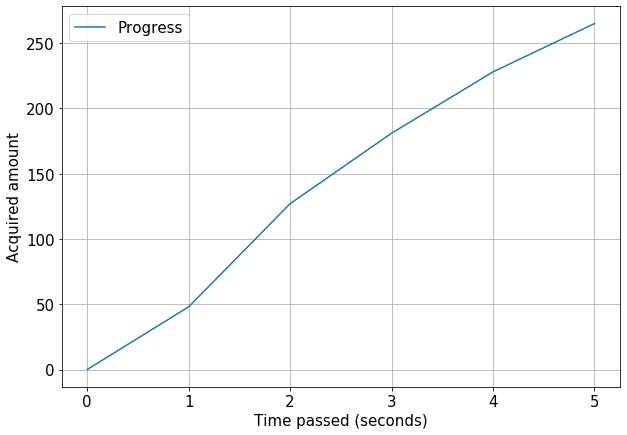

In [11]:
exp.graph()

## Now run the experiments

In [378]:
run_times = 4
# Define max records to stop computations early
# (this is just convenience so that the runs can stop early and we can do more simulations)
DB_RECORDS = 1000
timeouts = [60]
C_s = [-10 + (.5*x) for x in range(0, 41)]
limits = [1, 2, 3, 5, 10, 50]
orderings = ['random', 'fixed']
num_of_reports = 120

#DB_RECORDS = 10000
#timeouts = [180]
#C_s = [5]
#limits = [1, 10, 50]
#num_of_reports = 100

'''
run_experiments(
    timeouts = timeouts,
    C_s = C_s,
    limits = limits,
    orderings= orderings,
    output_csv = csv_out,
    num_of_reports = num_of_reports,
    wanted_sample = DB_RECORDS,
    run_times = run_times
)
'''

'\nrun_experiments(\n    timeouts = timeouts,\n    C_s = C_s,\n    limits = limits,\n    orderings= orderings,\n    output_csv = csv_out,\n    num_of_reports = num_of_reports,\n    wanted_sample = DB_RECORDS,\n    run_times = run_times\n)\n'

## Read the dataframe produced

In [380]:
df = pd.read_csv(csv_out, sep='|', header=0, index_col=False)
df

,Timeout,Limit,Ordering,C,Average depth,Average branching,Report frequency,Progress list,Acquired amount,Unaccepted amount
0,60,1,random,-10.0,19.175361,3.190446,0.5,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",4,3178
1,60,1,fixed,-10.0,15.355239,3.703814,0.5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,4351
2,60,2,random,-10.0,18.095465,3.379714,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4190
3,60,2,fixed,-10.0,14.566847,4.216914,0.5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,5924
4,60,3,random,-10.0,17.302079,3.433390,0.5,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",3,4713
...,...,...,...,...,...,...,...,...,...,...
569,60,10,fixed,10.0,13.000000,7.000000,0.5,"[125, 278, 376, 478, 559, 648, 707, 761, 810, ...",1000,0
570,60,20,random,10.0,13.301426,3.769857,0.5,"[343, 609, 785, 883, 941, 965, 986, 992, 993, ...",1000,0
571,60,20,fixed,10.0,12.319055,5.978583,0.5,"[301, 467, 556, 643, 675, 739, 779, 798, 827, ...",1000,0
572,60,50,random,10.0,11.215686,3.828431,0.5,"[540, 870, 964, 996]",1000,0


## Now let's try to get some intel from the runs we have ran
### Let's try to find what was the optimal value of C for different parameters
### Value of C is a factor to acceptance of a specific tuple at its depth and probability of traversal
### Let's plot it for better understanding

In [398]:
def plot_exp(*_, k: int) -> None:
    plt.title(f'Effect of C for different k\'s. Time: 1 minute')
    plt.xlabel('C value')
    plt.ylabel('Total amount acquired')
    plt.grid(True)
    plt.ylim(-100, DB_RECORDS+100)
    
    
    for k in [1, 10, 50]:
        top_k_df = df.loc[df['Limit'] == k]
        # Plot when random ordering
        random_ordered = list(top_k_df.merge(df.loc[df['Ordering'] == 'random'])['Acquired amount'])
        plt.plot(
            C_s,
            random_ordered,
            label=f'Random ordering for k = {k}',
            color=[1 if k == 50 else 0, 1 if k == 1 else 0, 1 if k == 10 else 0],
        )
    
    # Plot when fixed ordering
        fix_ordered = list(top_k_df.merge(df.loc[df['Ordering'] == 'fixed'])['Acquired amount'])
        plt.plot(
            C_s,
            fix_ordered,
            label=f'Fixed ordering for k = {k}',
            color=[0 if k == 50 else 1, 0 if k == 1 else .7, 0 if k == 10 else 1]
        )
    
    plt.legend(bbox_to_anchor=(1.04, 0.8))

## For k == 1

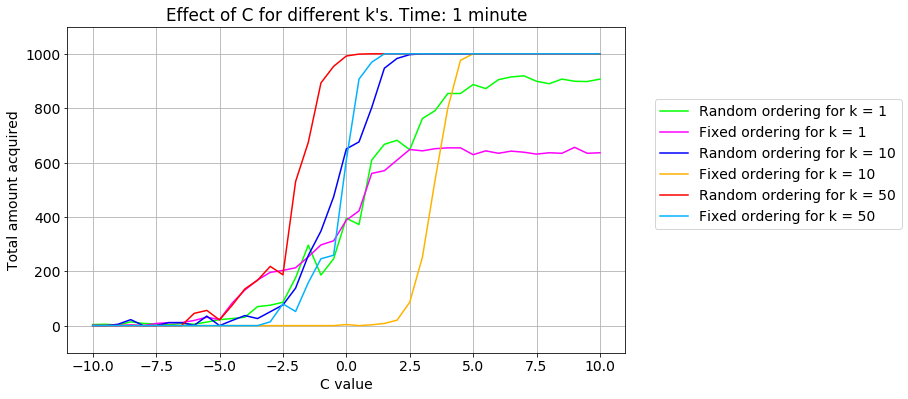

In [399]:
plot_exp(k=1)

## For k == 10

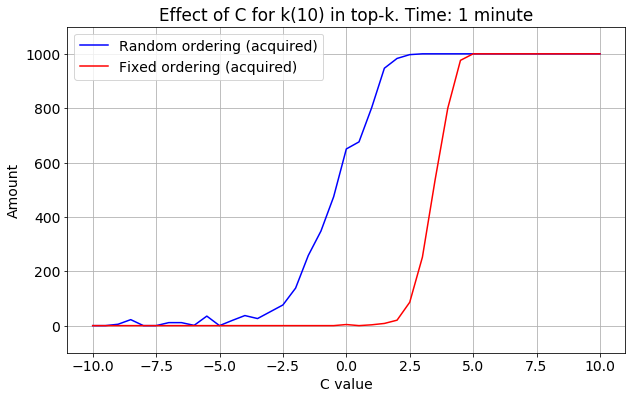

In [383]:
plot_exp(k=10)

## For k == 50

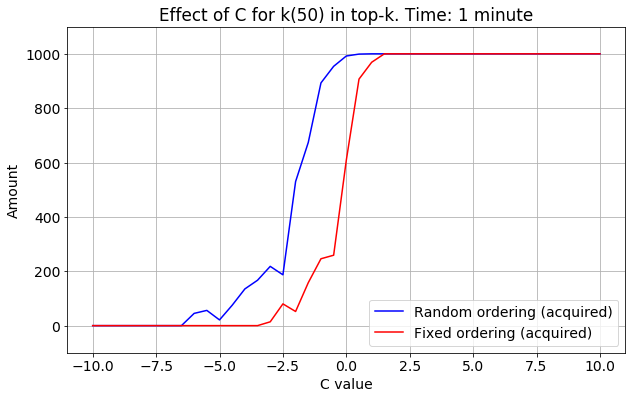

In [384]:
plot_exp(k=50)

## For k == 200

In [ ]:
plot_exp(k=200)

## For k == 10

In [ ]:
plot_exp(k=10)

## Let's not see the progress of products acquired relative to time passed per C

In [374]:
import ast

def plot_progress(*_, k: int) -> None:
    plt.title(f'Progress of products acquired for different k\'s')
    plt.xlabel('Time passed (seconds)')
    plt.ylabel('Amount acquired')
    plt.grid(True)
    plt.ylim(-100, DB_RECORDS+100)
    
    
    ## Plot these for legend
    
    for k in [1, 10, 50]:
        for C in C_s:
            top_k_df = df.loc[df['Limit'] == k]
            tmp_df = top_k_df.loc[top_k_df['C'] == C]
    
            # Plot when random ordering
            random_ordered = tmp_df.merge(top_k_df.loc[top_k_df['Ordering'] == 'random'])['Progress list'].to_list()
            for i in range(len(random_ordered)):
                ro = ast.literal_eval(random_ordered[i])
                time = [0+((180/num_of_reports)*x) for x in range(len(ro))]
            
                if C == 5 and i == 0:
                    plt.plot(
                        time,
                        ro,
                        color=[1 if k == 50 else 0, 1 if k == 1 else 0, 1 if k == 10 else 0],
                        label=f'Random ordering for k={k}'
                    )
                else:
                    plt.plot(
                        time,
                        ro,
                        color=[1 if k == 50 else 0, 1 if k == 1 else 0, 1 if k == 10 else 0]
                    )
    
            # Plot when fixed ordering
            fix_ordered = tmp_df.merge(top_k_df.loc[top_k_df['Ordering'] == 'fixed'])['Progress list'].to_list()
            for i in range(len(fix_ordered)):
                fo = ast.literal_eval(fix_ordered[0])
                time = [0+(180/num_of_reports)*x for x in range(len(fo))]
                if C == 5 and i == 0:
                    plt.plot(
                        time,
                        fo,
                        color=[0 if k == 50 else 1, 0 if k == 1 else .7, 0 if k == 10 else 1],
                        label=f'Fixed ordering for k={k}'
                    )
                else:
                    plt.plot(
                       time,
                       fo,
                       color=[0 if k == 50 else 1, 0 if k == 1 else .7, 0 if k == 10 else 1]
                    )
        
    
    plt.legend(bbox_to_anchor=(1.04, 0.8))

## The darker the color the lower the C is

## for k = 1

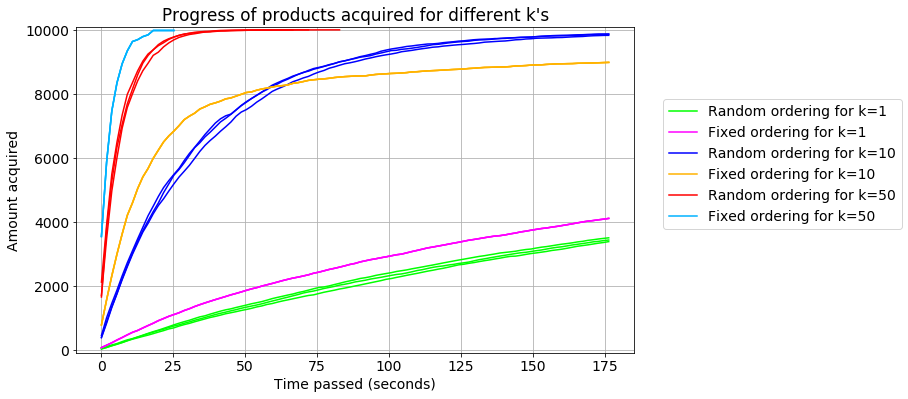

In [375]:
plot_progress(k=1)

### for k = 2

In [ ]:
plot_progress(k=10)

## for k = 3

In [ ]:
plot_progress(k=50)

## for k = 5

In [ ]:
plot_progress(k=200)

## and for k = 10

In [ ]:
plot_progress(k=10)